   # Salary Prediction Using Network Analysis 

## Predict the salary of employees in a given company based on their email  communication network using given attributes and extracting various features using Network Analysis.



# Import necessary libraries before loading data

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## What is Graph? 

###  The network or Graph is a representation of connections among a set of items. 
>  ###  Nodes : Items are called nodes.   
>  ###  Edges: Connections are called edges. 

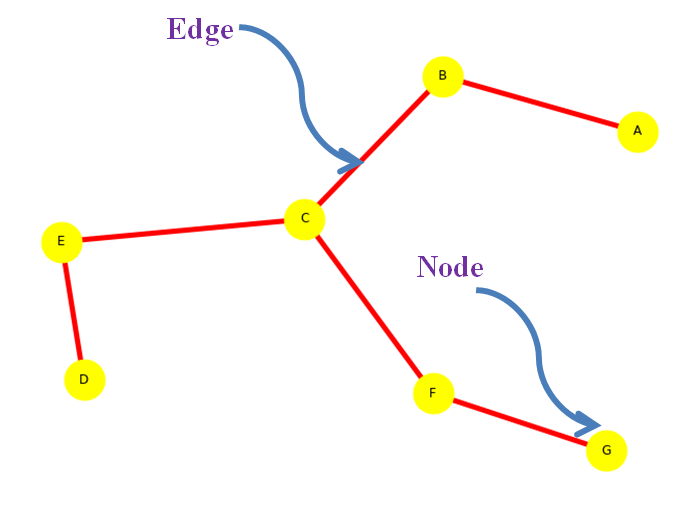

In [2]:
Image('network_pic.png')

## Network Examples:

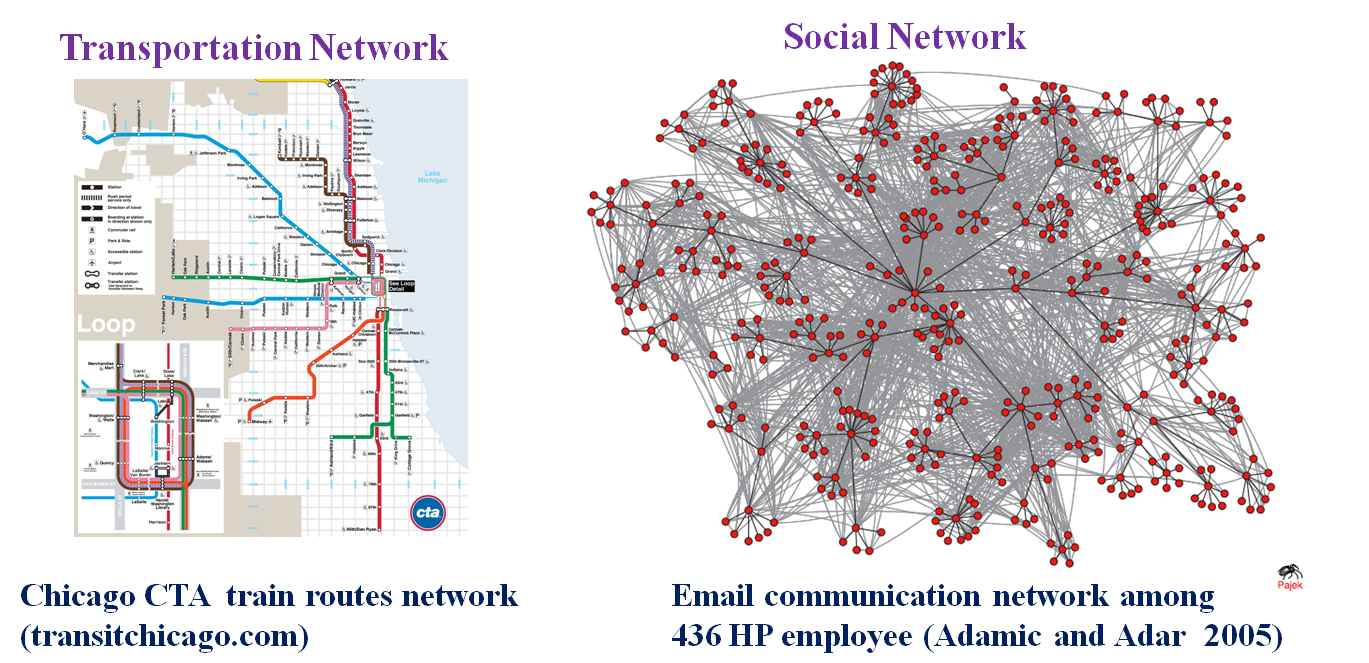

In [3]:
Image("sociotranport.PNG") 

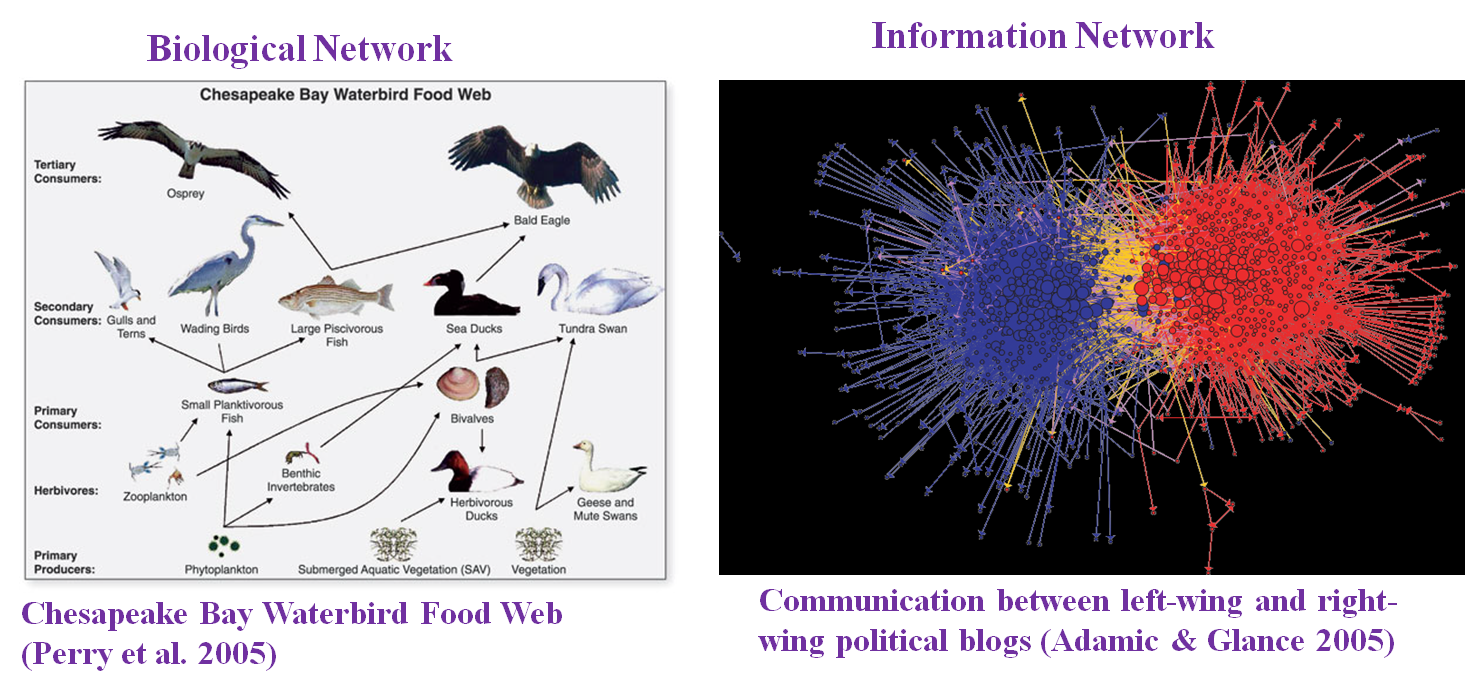

In [4]:
Image("bioinfo_network.PNG")

# Network Applications


 > ### Is a rumor likely to spread in this network?
 > ### Who are the influential people in this organization?
 > ### Is this organization is going to split into two groups?
 > ### Which airports are at highest risk for virus spreading? 


### The network G is the company's email network where each node corresponds to a person at the company and each edge indicates email communication between two people.

In [5]:
G = nx.read_gpickle('email_prediction.txt')
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16706
Average degree:  33.2458


In [6]:
#display(G.nodes(data = True))

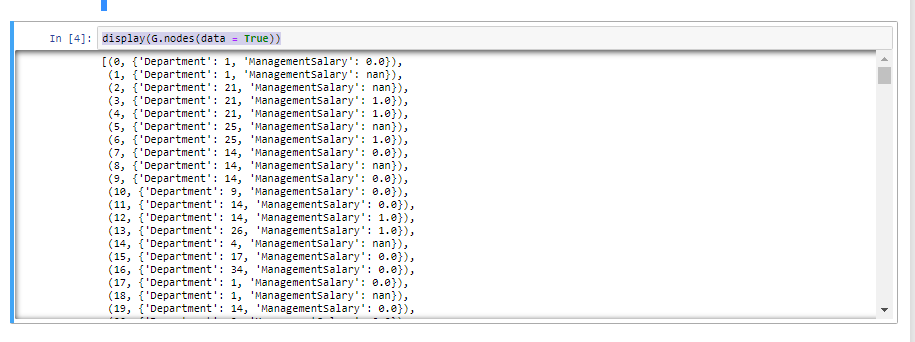

In [7]:
Image("Node_attributes.PNG")

### There are 1005  nodes with two node attributes: 
> ###  Department: Department is the department of the company where the person belongs to.
> ###  ManagementSalary: ManagementSalary tells whether the person is receiving a managment position salary.


### There are 16706 edges with no edge attributes:

In [8]:
#display(G.edges(data = True))

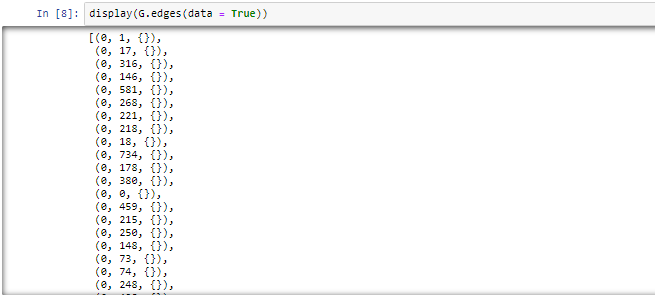

In [9]:
Image("Edge_attributes.PNG")

### Dataframe of nodes as index with corresponding attributes. 

In [10]:
df = pd.DataFrame(index = G.nodes())
df['ManagementSalary'] = pd.Series(nx.get_node_attributes(G, 'ManagementSalary'))
df['Department'] = pd.Series(nx.get_node_attributes(G, "Department"))
df.head(10)

,ManagementSalary,Department
0,0.0,1
1,NaN,1
2,NaN,21
3,1.0,21
4,1.0,21
5,NaN,25
6,1.0,25
7,0.0,14
8,NaN,14
9,0.0,14


In [11]:
df['ManagementSalary'].unique()

array([ 0., nan,  1.])

###  In managementSalary attribue, there are some missing values. We need to predict wheather or not these individuals with missing values are receiving a managment position salary. 

## Extract Node Features

### We will look at the important node features which will tell us about the influencers in the given network. 

### The best centrality measure depends on the context of the network one is analyzing. 
### Following are some measures of Network Centrality:

    
## Degree Centrality : 
### Important nodes have many connections.

 ##  $$C_{deg} (v) = \frac{d_v}{|N|-1}$$ <br>
  
 ### Where N is the set of nodes in the network, and $d_v$ is the degree(number of friends) of node $v$.



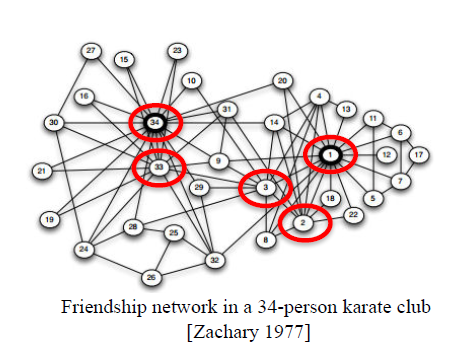

In [12]:
Image("Karate_club.PNG")

In [13]:
#nx.degree_centrality(G)

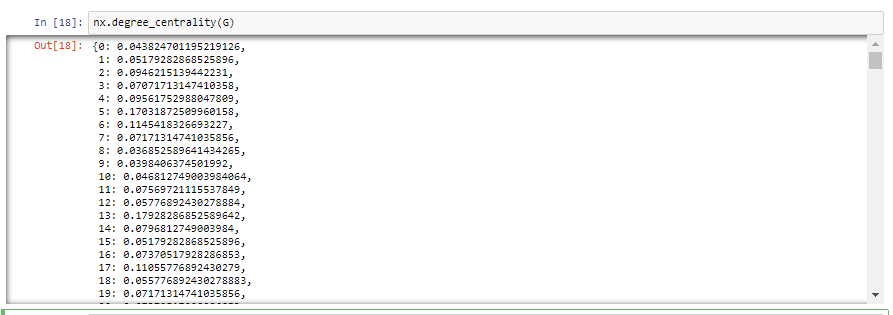

In [14]:
Image("Degree_Centrality.PNG")

## Closeness Centrality:
### Important nodes are close to other nodes. 

## $$C_{close}(v) = \frac{|N|-1}{\sum_{u} d(v,u)} $$

### Where N is the set of nodes in the network, and  $d(v,u)$ length of shortest path from $v$ to $u$ .

In [15]:
#nx.closeness_centrality(G)

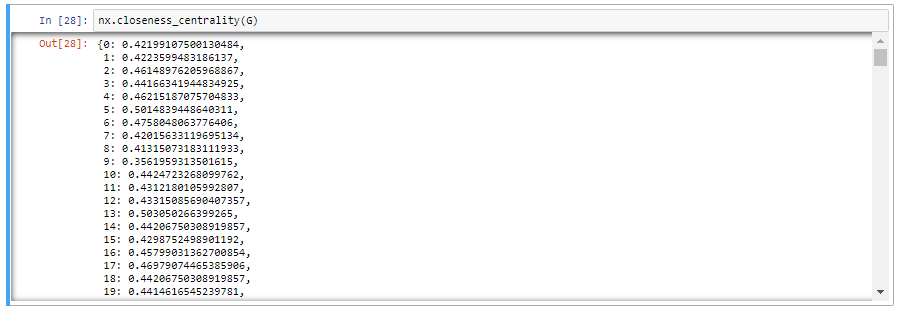

In [16]:
Image("Closeness_Centrality.PNG")

## Betweeness Centrality: 
### Important nodes connect other nodes. 

## $$C_{btw}(e) = \sum_{s,t \epsilon N} \frac{\sigma_{s,t}(e)}{\sigma_{s,t}} $$

### Where $\sigma_{s,t}(e)$ is the number of shortest paths between nodes $s$ and $t$  and  that passes through edge $e$, and $\sigma_{s,t}$  is the number of shortest paths between nodes $s$ and $t$. 



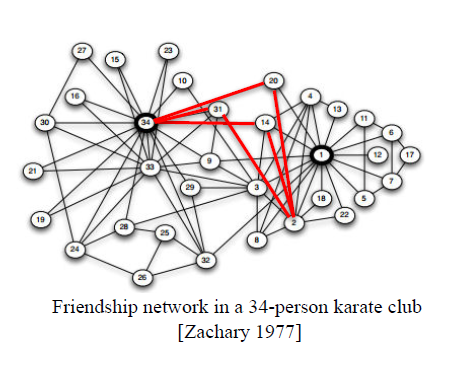

In [17]:
Image("Karate_club_betweeness.PNG")

In [18]:
#nx.betweenness_centrality(G)

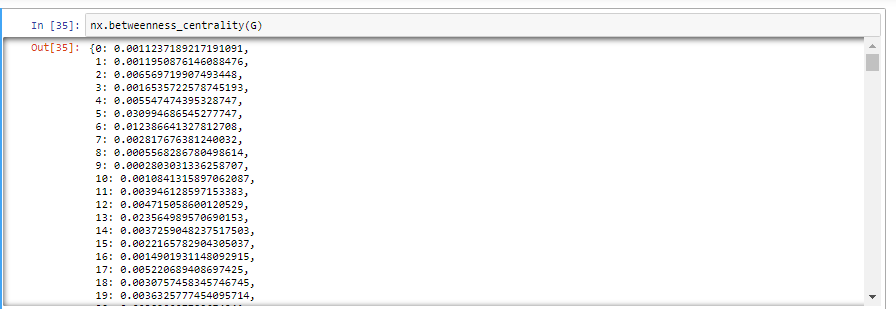

In [19]:
Image("Betweeness_Centrality.PNG")

## Local Clustering Coefficient: 
### Fraction of pairs of the node's friends that are friends with each other.
###  The local clustering coefficient of node C = # of pairs of C's friends who are friend / # of pairs of C's friends 

### # of C's friends = $d_c$ = 4  ( degree of C)
### # of pairs of C's friends = $\frac{d_c(d_c -1)}{2}$ = $\frac{12}{2}$ = 6

### # of pairs of C's friends who are also friends = 2 

###  Local clustering coefficient of C = $\frac{2}{6}$ = $\frac{1}{3}$

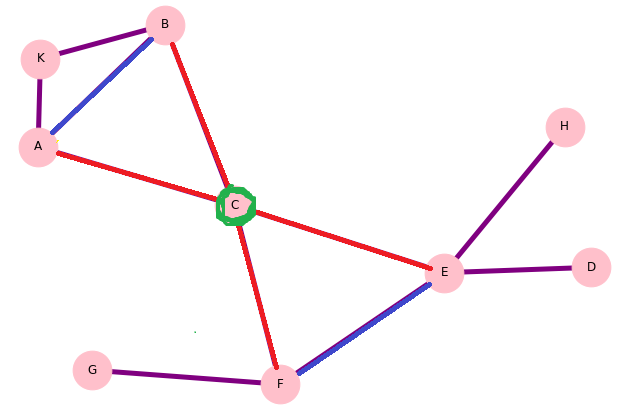

In [20]:
Image('network_example4.PNG')

In [21]:
#nx.clustering(G)

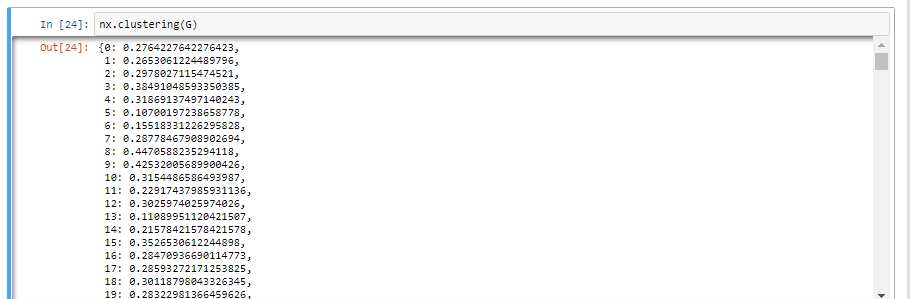

In [22]:
Image('Local_Clustering.PNG')

##  Add these features to dataframe

In [23]:
df['Degree'] = pd.Series(nx.degree_centrality(G))
df['Closeness'] = pd.Series(nx.closeness_centrality(G))
df['Betweenness'] = pd.Series(nx.betweenness_centrality(G))
df['Clustering'] = pd.Series(nx.clustering(G))
df.head(10)

,ManagementSalary,Department,Degree,Closeness,Betweenness,Clustering
0,0.0,1,0.043825,0.421991,0.001124,0.276423
1,NaN,1,0.051793,0.422360,0.001195,0.265306
2,NaN,21,0.094622,0.461490,0.006570,0.297803
3,1.0,21,0.070717,0.441663,0.001654,0.384910
4,1.0,21,0.095618,0.462152,0.005547,0.318691
5,NaN,25,0.170319,0.501484,0.030995,0.107002
6,1.0,25,0.114542,0.475805,0.012387,0.155183
7,0.0,14,0.071713,0.420156,0.002818,0.287785
8,NaN,14,0.036853,0.413151,0.000557,0.447059
9,0.0,14,0.039841,0.356196,0.000280,0.425320


## Separate dataframe based on null on ManagementSalary

In [24]:
# Input data with known management salary 
dfnot_null = df[df.ManagementSalary.notnull()].iloc[:,0:6]
display(dfnot_null)
Xnot_null = df[df.ManagementSalary.notnull()].iloc[:,1:6]
ynot_null = df[df.ManagementSalary.notnull()].iloc[:,0]  # target variable

# Input data with unknown management salary 
X_pred = df[df.ManagementSalary.isnull()].iloc[:,1:6]
df_predict = X_pred.copy()
display(df_predict) 

,ManagementSalary,Department,Degree,Closeness,Betweenness,Clustering
0,0.0,1,0.043825,0.421991,0.001124,0.276423
3,1.0,21,0.070717,0.441663,0.001654,0.384910
4,1.0,21,0.095618,0.462152,0.005547,0.318691
6,1.0,25,0.114542,0.475805,0.012387,0.155183
7,0.0,14,0.071713,0.420156,0.002818,0.287785
...,...,...,...,...,...,...
998,0.0,14,0.000996,0.313753,0.000000,0.000000
999,0.0,15,0.000996,0.311729,0.000000,0.000000
1002,0.0,1,0.000996,0.297983,0.000000,0.000000
1003,0.0,6,0.000996,0.298167,0.000000,0.000000


,Department,Degree,Closeness,Betweenness,Clustering
1,1,0.051793,0.422360,0.001195,0.265306
2,21,0.094622,0.461490,0.006570,0.297803
5,25,0.170319,0.501484,0.030995,0.107002
8,14,0.036853,0.413151,0.000557,0.447059
14,4,0.079681,0.442068,0.003726,0.215784
...,...,...,...,...,...
992,4,0.002988,0.332998,0.000000,0.000000
994,21,0.000996,0.320517,0.000000,0.000000
996,14,0.000996,0.300578,0.000000,0.000000
1000,4,0.005976,0.355934,0.000004,0.600000


## Exploratatory Data Analysis 

In [25]:
dfnot_null.head()

,ManagementSalary,Department,Degree,Closeness,Betweenness,Clustering
0,0.0,1,0.043825,0.421991,0.001124,0.276423
3,1.0,21,0.070717,0.441663,0.001654,0.384910
4,1.0,21,0.095618,0.462152,0.005547,0.318691
6,1.0,25,0.114542,0.475805,0.012387,0.155183
7,0.0,14,0.071713,0.420156,0.002818,0.287785


In [26]:
#Quick way to see the structure of the dataset 
dfnot_null.shape

(753, 6)

In [27]:
#Check out the variable types
dfnot_null.dtypes

ManagementSalary    float64
Department            int64
Degree              float64
Closeness           float64
Betweenness         float64
Clustering          float64
dtype: object

In [28]:
#Gives concise summary of the dataframe: index dtype, column dtypes, non_null values, memory usuage
dfnot_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 753 entries, 0 to 1004
Data columns (total 6 columns):
ManagementSalary    753 non-null float64
Department          753 non-null int64
Degree              753 non-null float64
Closeness           753 non-null float64
Betweenness         753 non-null float64
Clustering          753 non-null float64
dtypes: float64(5), int64(1)
memory usage: 41.2 KB


In [29]:
#Check if there is null value
dfnot_null.isnull().values.any()

False

### From a total of 753 entries, there are no missing values, and all are numeric variables (float64).

In [30]:
# Gives some basic statistics of the numerical variables in the dataset
dfnot_null.describe()

,ManagementSalary,Department,Degree,Closeness,Betweenness,Clustering
count,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000
mean,0.158035,13.737052,0.033539,0.379491,0.001585,0.395150
std,0.365016,10.256286,0.037910,0.076288,0.004708,0.252051
min,0.000000,0.000000,0.000996,0.000000,0.000000,0.000000
25%,0.000000,4.000000,0.005976,0.344759,0.000005,0.264550
50%,0.000000,13.000000,0.022908,0.387785,0.000184,0.371542
75%,0.000000,20.000000,0.045817,0.425334,0.001265,0.523810
max,1.000000,41.000000,0.345618,0.573848,0.087415,1.000000


## Density plots of node features

In [31]:
def density_plot(data):
    pd.DataFrame(data).plot(kind = 'density', color = 'purple', linewidth = 5, figsize = (12,8))    

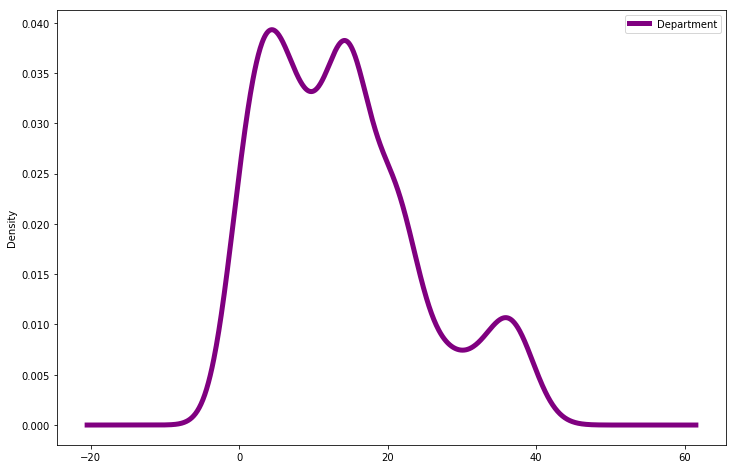

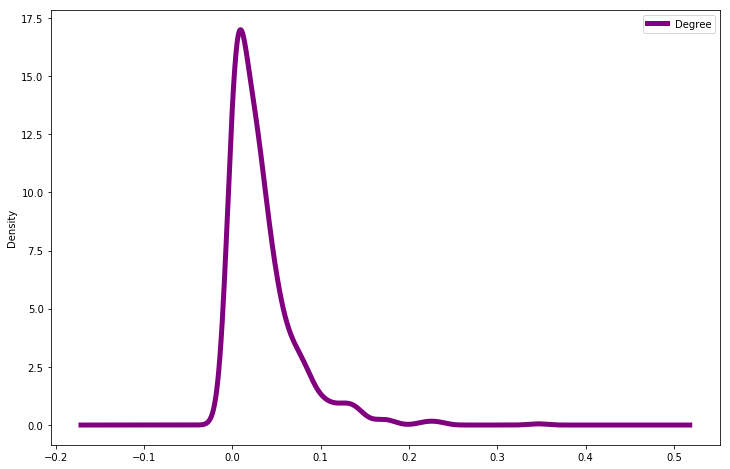

In [32]:
density_plot(dfnot_null['Department'])
density_plot(dfnot_null['Degree'])

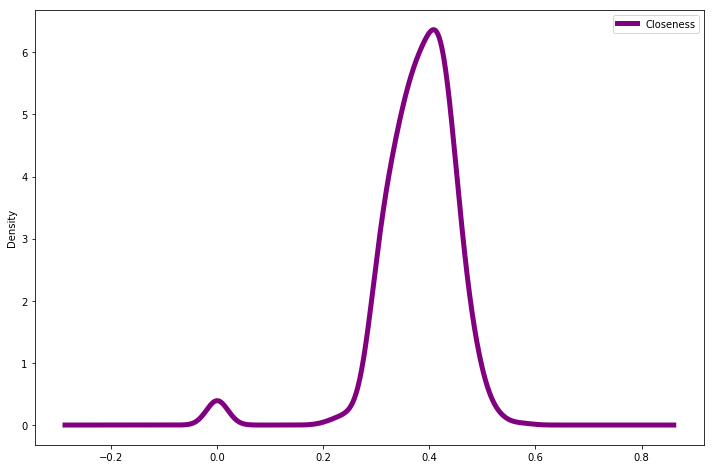

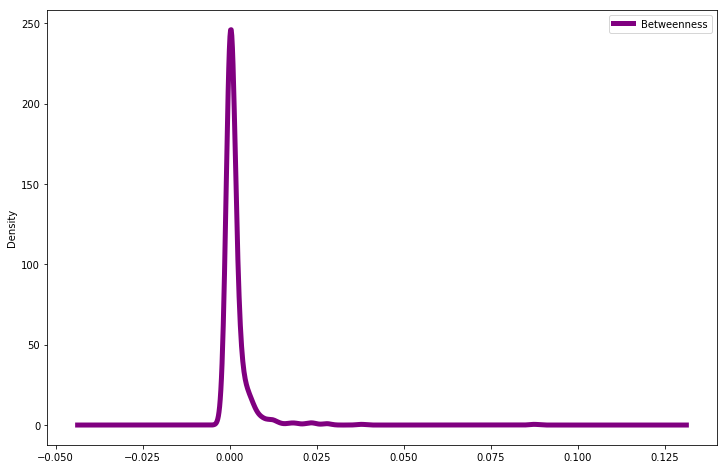

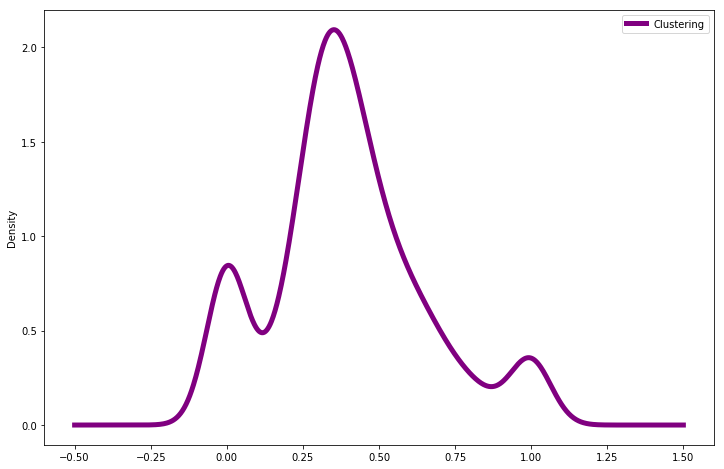

In [33]:
density_plot(dfnot_null['Closeness'])
density_plot(dfnot_null['Betweenness'])
density_plot(dfnot_null['Clustering'])

## Split the dataset 
### Splitting input data into training and test dataset

In [34]:
def split_fun():
    X_train, X_test, y_train, y_test = train_test_split(Xnot_null, ynot_null, random_state = 0)
    return X_train, X_test, y_train, y_test   

# Modeling 

## Logistic Regression 

In [35]:
X_train, X_test, y_train, y_test = split_fun()

# Building model 
logRegClassifier = LogisticRegression(solver='lbfgs')


# Training model 
logRegClassifier.fit(X_train, y_train)



#Test model 
y_score_lgr = logRegClassifier.decision_function(X_test)


# Evaluate performance
fpr, tpr, _ = roc_curve(y_test, y_score_lgr)
roc_auc = auc(fpr, tpr)

print('Training Accuracy Score :\t', logRegClassifier.score(X_train, y_train))
print('Test Accuracy Score :\t\t', logRegClassifier.score(X_test, y_test))
print('AUC Score :\t\t\t', roc_auc)

Training Accuracy Score :	 0.849290780141844
Test Accuracy Score :		 0.8518518518518519
AUC Score :			 0.780712788259958


## Cross_Validation 

In [36]:
X_train, X_test, y_train, y_test = split_fun()

# Building model 
model = LogisticRegression(solver='lbfgs')

#Cross validation 
cross_val = KFold(n_splits = 3, random_state = 42)

# Evaluate performance
scores = cross_val_score(model, X_train, y_train, cv = cross_val, scoring = 'roc_auc')
print("Mean AUC score - LogisticRegression: ", scores.mean())

Mean AUC score - LogisticRegression:  0.7865255918497205


# Logistic Regression with Feature normalization 

### Standarization technique  transforms attributes with Gaussian distribution into standard Gaussian distribution  with mean 0 and a standard deviation of 1.

In [37]:
X_train, X_test, y_train, y_test = split_fun()

# Fit the scalar with training set 
scaler = StandardScaler().fit(X_train)

# Apply the same scalar to transform the training and test set.
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)  
X_pred = scaler.transform(X_pred)

# Building model 
logRegClassifier = LogisticRegression(solver='lbfgs')

# Trainng model 
logRegClassifier.fit(X_train, y_train)


# Test model
y_score_lgs = logRegClassifier.decision_function(X_test)


# Evaluate performance
fpr, tpr, _ = roc_curve(y_test, y_score_lgs)
roc_auc = auc(fpr, tpr)


print('Training Accuracy Score :\t', logRegClassifier.score(X_train, y_train))
print('Test  Accuracy Score :\t\t', logRegClassifier.score(X_test, y_test))
print('AUC Score :\t\t\t', roc_auc)



# Predictions
y_pred = [a[0] for a in list(logRegClassifier.predict_proba(X_pred))]
y_final = pd.Series(y_pred)
df_predict['ManagementSalary'] = y_final.values

Training Accuracy Score :	 0.900709219858156
Test  Accuracy Score :		 0.8941798941798942
AUC Score :			 0.918448637316562


## Cross_Validation 

In [38]:
X_train, X_test, y_train, y_test = split_fun()

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)  
X_pred = scaler.transform(X_pred)

# Building model 
model = LogisticRegression(solver='lbfgs')

#Cross validation 
cross_val = KFold(n_splits = 3, random_state = 42)


# Evaluate performance
scores = cross_val_score(model, X_train, y_train, cv = cross_val, scoring = 'roc_auc')
print("Mean AUC score - LogisticRegression with standarized transformation: ", scores.mean())

Mean AUC score - LogisticRegression with standarized transformation:  0.9317725736138508


# GradientBoosting Classifier

In [39]:
X_train, X_test, y_train, y_test = split_fun()

# Building model 
gb = GradientBoostingClassifier()

# Trainng model
gb.fit(X_train, y_train)


# Test model
y_score_gb = gb.decision_function(X_test)

# Evaluate performance
fpr, tpr, _ = roc_curve(y_test, y_score_gb)
roc_auc = auc(fpr, tpr)
#auc = roc_auc_score(y_test, y_score_gb)


print('Training Accuracy Score :\t', gb.score(X_train, y_train))
print('Test Accuracy Score :\t\t', gb.score(X_test, y_test))
print('AUC Score :\t\t\t', roc_auc)

Training Accuracy Score :	 0.9964539007092199
Test Accuracy Score :		 0.8888888888888888
AUC Score :			 0.929769392033543


# Cross Validation

In [40]:
X_train, X_test, y_train, y_test = split_fun()

 
model = GradientBoostingClassifier()

#Cross validation 
cross_val = KFold(n_splits = 3, random_state = 42)


# Evaluate performance
scores = cross_val_score(model, X_train, y_train, cv = cross_val, scoring = 'roc_auc')
print("Mean AUC score - Gradient Boosting Classifier: ", scores.mean())

Mean AUC score - Gradient Boosting Classifier:  0.9472203190390767


# RandomForest Classifier

In [41]:
X_train, X_test, y_train, y_test = split_fun()


# Building model 
rf =RandomForestClassifier()

# Trainng model
rf.fit(X_train, y_train)


# Test model
y_score_rf = rf.fit(X_train, y_train).predict(X_test)


# Evaluate performance
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)


print('Training Accuracy Score :\t', rf.score(X_train, y_train))
print('Test Accuracy Score :\t\t', rf.score(X_test, y_test))
print('AUC Score :\t\t\t', roc_auc_rf)


Training Accuracy Score :	 0.9929078014184397
Test Accuracy Score :		 0.8888888888888888
AUC Score :			 0.6635220125786163


# Results:

In [42]:
df_predict.head(20)

,Department,Degree,Closeness,Betweenness,Clustering,ManagementSalary
1,1,0.051793,0.422360,0.001195,0.265306,0.954940
2,21,0.094622,0.461490,0.006570,0.297803,0.282587
5,25,0.170319,0.501484,0.030995,0.107002,0.000095
8,14,0.036853,0.413151,0.000557,0.447059,0.892215
14,4,0.079681,0.442068,0.003726,0.215784,0.846386
18,1,0.055777,0.442068,0.003076,0.301188,0.777593
27,11,0.062749,0.430258,0.003117,0.368852,0.762140
30,11,0.067729,0.443284,0.001694,0.402797,0.685343
31,11,0.049801,0.418156,0.000399,0.412234,0.905741
34,11,0.030876,0.382565,0.000115,0.637931,0.903857


# Classification 

In [43]:
df_predict_result = df_predict.copy()

In [44]:
test_list= df_predict_result.ManagementSalary
answer_list = [1.0 if p>=0.5 else 0.0 for p in test_list]
df_predict_result['ManagementSalary'] = np.array(answer_list)
df_predict_result.head(10)

,Department,Degree,Closeness,Betweenness,Clustering,ManagementSalary
1,1,0.051793,0.422360,0.001195,0.265306,1.0
2,21,0.094622,0.461490,0.006570,0.297803,0.0
5,25,0.170319,0.501484,0.030995,0.107002,0.0
8,14,0.036853,0.413151,0.000557,0.447059,1.0
14,4,0.079681,0.442068,0.003726,0.215784,1.0
18,1,0.055777,0.442068,0.003076,0.301188,1.0
27,11,0.062749,0.430258,0.003117,0.368852,1.0
30,11,0.067729,0.443284,0.001694,0.402797,1.0
31,11,0.049801,0.418156,0.000399,0.412234,1.0
34,11,0.030876,0.382565,0.000115,0.637931,1.0


# Original dataframe

In [45]:
df_original = df.copy()
df_original = df_original.drop(['Degree','Closeness', 'Betweenness', 'Clustering'], axis = 1) 
df_original

,ManagementSalary,Department
0,0.0,1
1,NaN,1
2,NaN,21
3,1.0,21
4,1.0,21
...,...,...
1000,NaN,4
1001,NaN,21
1002,0.0,1
1003,0.0,6


# Predicted ManagementSalary values

In [46]:
columns_reorder = ['ManagementSalary', 'Department']
df_final = df_predict_result.copy()
df_final = df_final.drop(['Degree','Closeness', 'Betweenness', 'Clustering'], axis = 1)
df_final = df_final.reindex(columns = columns_reorder)
df_final

,ManagementSalary,Department
1,1.0,1
2,0.0,21
5,0.0,25
8,1.0,14
14,1.0,4
...,...,...
992,1.0,4
994,1.0,21
996,1.0,14
1000,1.0,4


In [47]:
df_test = df_original.combine_first(df_final) 
df_test

,ManagementSalary,Department
0,0.0,1
1,1.0,1
2,0.0,21
3,1.0,21
4,1.0,21
...,...,...
1000,1.0,4
1001,1.0,21
1002,0.0,1
1003,0.0,6
